\author{Brice Robert} 

***Student:*** Brice Robert, ***Track:*** ICS

***Document:*** REPORT.pdf, ***Type:*** Laboratory

***Languages used:*** LaTeX, Julia (in lieu of MATLAB)

***Tools used:*** Jupyter, nbconvert (converting to PDF)

***Permanent Link:*** https://github.com/setrar/MobCom/blob/main/Lab/REPORT.ipynb

| MATLAB PROJECT for MOBCOM |
|:-:|
| EURECOM |
| November 21st, 2024 |
| Class Instructor: Petros Elia |
| elia@eurecom.fr |

- Read carefully the following questions, and using MATLAB, provide the answers/plots in the form of a report.
- The report should include a title page, and should be properly labeled and named. The report should be in the form of a PDF.
- Graphs should include labels, titles, and captions.
- Each graph should be accompanied with pertinent comments.
- Use optimal (maximum likelihood) decoders, unless stated otherwise.
- To compare the empirical results with the corresponding theoretical result, you should superimpose the two corresponding graphs and provide comments and intuition on the comparison.
- For each plot, describe the theoretical background that guides the proper choice of parameters for simulations (i.e., power constraint).
- You can work in groups of two or three.


- Regarding Grading:
    - All questions are weighted equally.
    - Submit your report (labeled and named) via email, to Hui Zhao (Hui.Zhao@eurecom.fr) and to myself.
    - Submission deadline is December 12th, 2024.




Enjoy!






---
**$$\text{PROBLEM 1}$$**

Consider communication over the $1 \times 1$ quasi-static fading channel, using 16-PAM. The channel model is given by  

$$
\overbrace{( y )}^{y} = \theta \overbrace{(h)}^{h} \overbrace{(x)}^{\text{16-PAM:}X_{\text{tr}}} + \overbrace{( w )}^{w}
$$

where $h \sim \mathbb{C}N(0, 1)$ (Gaussian Fading) and $w \sim \mathbb{C}N(0, 2)$, and where $\theta$ is the power normalization factor that lets you regulate SNR.  

Here, you are supposed to do a simulation of the action of decoding. **PROVIDE THE DETAILS OF HOW YOU SIMULATED.** Tell us which variables you change in each iteration: $h$, codewords, noise, and tell us how you power normalize (emphasis on $\theta$) so that you achieve a certain signal-to-noise ratio (SNR). Naturally, in each iteration, you decode, using the maximum-likelihood (ML) rule that we learned about:

$\hat{x} = \arg \min_{x \in \mathcal{X}_{\text{tr}}} \|y - \theta h \cdot x \|^2$

going over all choices of $x$ in the code $\mathcal{X}_{\text{tr}}$.

**NOTE:** Do many iterations so that your plots are "smooth." In all the above, the y-axis is the probability of error, in log scale ($\log_{10}(\text{Prob})$), and the x-axis is the SNR, in dB.  

- **Plot the probability of error** on a logarithmic scale as a function of SNR (dB) by performing Monte-Carlo simulations for when $x$ are independently chosen from 16-PAM.  

For the above, use the ML decoder, and plot for SNR values — in steps of 3 dB — up to an SNR value for which your probability of error drops below $5 \times 10^{-5}$. **Again, clearly explain how you calculate $\theta$ in each case.**  

---
Import Required Libraries


In [1]:
using Random
using Distributions
using LinearAlgebra
using Plots, LaTeXStrings, Measures 
using FFTW

In [2]:
# functions and variables to increase readability
include("modules/operations.jl");

In [17]:
# Define base values and offsets
base_values = [-0.00, -0.50, -1.00, -1.50, -2.00]
offsets = [-0.0, -0.02, -0.10, -0.15, -0.20, -0.30, -0.40, -0.70]
include("modules/view_helper.jl");

Step 2: Define Parameters

Set the simulation parameters:

In [4]:
# Parameters (only the constants)
const M = 16  # 16-PAM
const σ² = 2.0  # Noise variance
const SNR_dB_range = 0:3:30;  # SNR range in dB

Step 3: Generate 16-PAM Symbol Set

Define the 16-PAM constellation:

In [5]:
# Generate 16-PAM constellation
function generate_16pam()
    levels = -15:2:15  # PAM levels
    return collect(levels)  # Return as an array
end

Xₜᵣ = generate_16pam() ; @show typeof(Xₜᵣ), Xₜᵣ;  # Shows the Transmitted symbol set

(typeof(Xₜᵣ), Xₜᵣ) = (Vector{Int64}, [-15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15])


Step 4: Define Channel Model and Noise

1.	Gaussian Fading Channel ($\tilde{h} \sim \mathcal{CN}(0, 1)$):

In [6]:
# Generate Gaussian fading channel
function generate_gaussian_fading(n)
    real_part = rand(Normal(0, 1), n)  # Real part
    imag_part = rand(Normal(0, 1), n)  # Imaginary part
    return real_part .+ im .* imag_part  # Complex Gaussian
end;

2.	Additive Noise $(\tilde{w} \sim \mathcal{CN}(0, \sigma²))$:

In [7]:
# Generate complex Gaussian noise
function generate_noise(n, σ²)
    real_part = rand(Normal(0, sqrt(σ² / 2)), n)
    imag_part = rand(Normal(0, sqrt(σ² / 2)), n)
    return real_part .+ im .* imag_part
end;

Step 5: Power Normalization

Compute the normalization factor $\theta$ based on the $SNR$:

In [8]:
# Compute power normalization factor
function compute_θ(SNR_dB, σ², Xₜᵣ)
    SNRₗᵢₙₑₐᵣ = 10^(SNR_dB / 10)  # Convert SNR from dB to linear scale
    Pₓ = mean(abs2.(Xₜᵣ))  # Average power of 16-PAM symbols
    return sqrt((SNRₗᵢₙₑₐᵣ * σ²) / Pₓ)  # Calculate θ
end;

Step 6: ML Decoding Rule

Implement the ML decoding rule:

In [9]:
# ML decoding
function ml_decode(ŷ, h, θ, Xₜᵣ)
    distances = abs2.(ŷ .- θ .* h .* Xₜᵣ)  # Compute distances for all symbols
    idx = argmin(distances)  # Find the index of the minimum distance
    return Xₜᵣ[idx]  # Return the estimated symbol
end;

Step 7: Monte Carlo Simulation

Simulate the system and calculate the probability of error:

In [10]:
# Monte Carlo simulation
function monte_carlo_simulation(SNR_dB_range, n_samples, σ², X_tr)
    P_error = Float64[]

    for SNR_dB in SNR_dB_range
        θ = compute_θ(SNR_dB, σ², X_tr)  # Compute normalization factor
        h = generate_gaussian_fading(n_samples)  # Generate fading coefficients
        x = rand(X_tr, n_samples)  # Randomly transmit symbols
        w = generate_noise(n_samples, σ²)  # Generate noise
        ŷ = θ .* h .* x .+ w  # Received signal

        # Perform decoding
        x̂ = [ml_decode(ŷ[i], h[i], θ, X_tr) for i in 1:n_samples]

        # Compute error probability
        error_count = count(x .!= x̂)
        push!(P_error, error_count / n_samples)
    end

    return P_error
end;

Step 8: Plot Results

Plot the probability of error vs. SNR (logarithmic scale):

P_error = [0.795997, 0.738788, 0.662925, 0.565179, 0.449493, 0.32472, 0.213301, 0.127217, 0.06992, 0.037029, 0.019362]


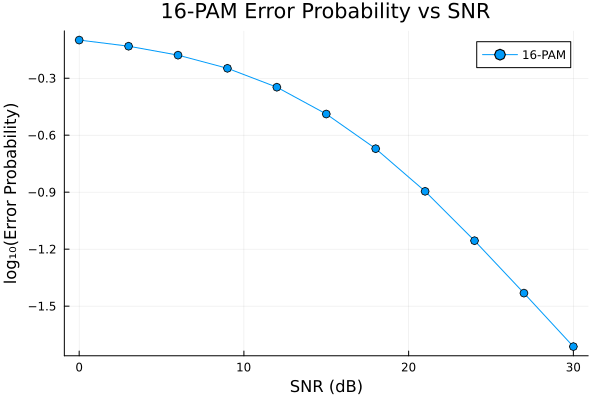

In [19]:
# Parameters
n_samples = 10^6  # Number of Monte Carlo samples

# Run the simulation
P_error = monte_carlo_simulation(SNR_dB_range, n_samples, σ², Xₜᵣ); @show P_error;

# Plot results
plot(SNR_dB_range, log10.(P_error)
    , marker=:o, label="16-PAM"
    , xlabel="SNR (dB)", ylabel="log₁₀(Error Probability)"
    , title="16-PAM Error Probability vs SNR"
    , grid=true
)
# add_combined_hlines!(offsets, base_values, linestyle=:dash, lw=1, color=:gray, alpha=0.3)


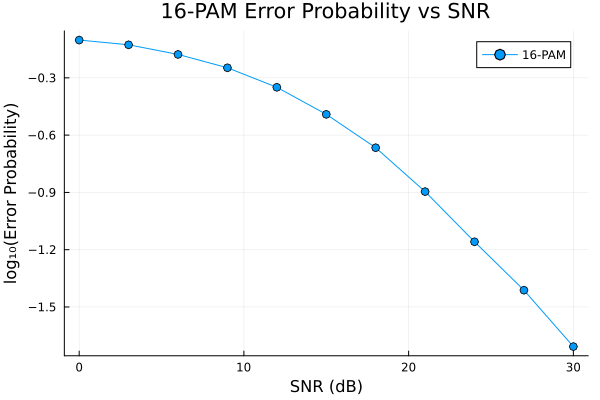

In [12]:
# Parameters
n_samples = 10^4  # Number of Monte Carlo samples

# Run the simulation
P_error = monte_carlo_simulation(SNR_dB_range, n_samples, σ², Xₜᵣ)

# Plot results
plot(SNR_dB_range, log10.(P_error)
    , marker=:o, label="16-PAM"
    , xlabel="SNR (dB)", ylabel="log₁₀(Error Probability)"
    , title="16-PAM Error Probability vs SNR"
    , grid=true
)

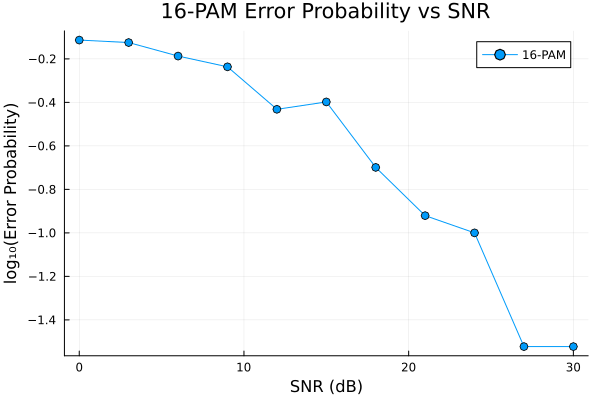

In [13]:
n_samples = 10^2  # Number of Monte Carlo samples

# Run the simulation
P_error = monte_carlo_simulation(SNR_dB_range, n_samples, σ², Xₜᵣ)

# Plot results
plot(SNR_dB_range, log10.(P_error)
    , marker=:o, label="16-PAM"
    , xlabel="SNR (dB)", ylabel="log₁₀(Error Probability)"
    , title="16-PAM Error Probability vs SNR"
    , grid=true
)

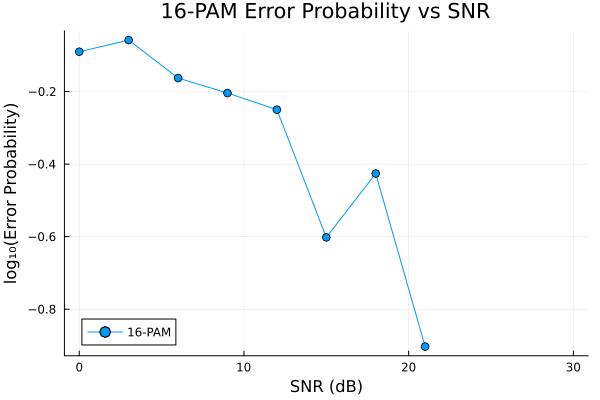

In [14]:
n_samples = 16  # Number of Monte Carlo samples

# Run the simulation
P_error = monte_carlo_simulation(SNR_dB_range, n_samples, σ², Xₜᵣ)

# Plot results
plot(SNR_dB_range, log10.(P_error)
    , marker=:o, label="16-PAM"
    , xlabel="SNR (dB)", ylabel="log₁₀(Error Probability)"
    , title="16-PAM Error Probability vs SNR"
    , grid=true
)

---
**$$\text{PROBLEM 2}$$**


- **Use simulations to establish the probability of deep fade**  

$$
P(\|h\|^2 < \text{SNR}^{-1})
$$

for the random fading model:

$$
y = h \cdot x + w
$$

where $w \sim \mathbb{C}N(0, 1)$, and where $h$ is a Rician random variable, where you can choose the parameters of this distribution.

- **Now do the same when $h$ is now a 3-length vector with i.i.d. Rician elements.**

In all the above, the y-axis is the probability of deep fade, in log scale ($\log_{10}(\text{Prob})$), and the x-axis is the SNR, in dB.

---
**$$\text{PROBLEM 3}$$**

Use simulations to establish the probability of deep fade  

$P(\|\tilde{h}\|^2 < \text{SNR}^{-1})$

where $\|\tilde{h}\|^2$ now comes from the $\chi^2$-squared fading distribution with $2 \times 3 = 6$ degrees of freedom.

- **What do you observe compared to the previous two problems?**

In all the above, the y-axis is the probability of deep fade, in log scale ($\log_{10}(\text{Prob})$), and the x-axis is the SNR, in dB.  

---
**$$\text{PROBLEM 4}$$**

Create different experiments to check the validity of the following:

- For Gaussian random variables $h_r \sim \mathcal{N}(0, \sigma)$, the far tail is approximated by an exponential, i.e.,  $
Q(\alpha) \approx e^{-\alpha^2 / 2 z}.
$  Identify what is $z$ in this case.

- For $h \sim \mathbb{C}\mathcal{N}(0, 1)$, the near-zero behavior is approximated as follows:  

$$
P(\|h\|^2 < \epsilon) \approx \epsilon.
$$ 

- Same as the above, but for $h \sim CN(0, 5)$. Show how the near-zero behavior is approximated.

**NOTE:** The important thing in the above exercise is to describe **IN DETAIL** the way you perform the different experiments, as well as the results.

**NOTE:**  We need statistical experiments, i.e., experiments that involve the generation of random variables, and the measuring of their behavior using — if you wish — histograms.

In [15]:
# '/.